In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(1, '/home/georgeos/Documents/GitHub/SyMBac/') # Not needed if you installed SyMBac using pip
sys.path.insert(1, '/home/georgeos/Documents/Github/SyMBac/') # Not needed if you installed SyMBac using pip


from SyMBac.drawing import raster_cell, OPL_to_FL
from SyMBac.PSF import PSF_generator
from SyMBac.renderer import convolve_rescale
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
from PIL import Image
from skimage.util import img_as_uint
import os
import zarr
from numcodecs import Blosc
from joblib import Parallel, delayed
from glob import glob

In [3]:
def generate_FL_cells(density):
    FL_cell = np.pad(
        OPL_to_FL(cell, density = density),
        ((100,100),(200,200))
    )
    return FL_cell

In [6]:
try:
    os.mkdir("convolutions")
except:
    pass

In [7]:
compressor = Blosc(cname='zstd', clevel=1, shuffle=Blosc.BITSHUFFLE)

In [8]:
lengths = np.arange(1,11,1)
widths = np.arange(1,11,1)
densities = np.linspace(1,100, 10)
NAs = np.linspace(0.5, 1.45, 5)
ns = np.linspace(1, 1.518, 5)
wavelengths = [0.45, 0.5, 0.575,  0.65]
names = ["blue", "green", "orange", "far red"]
resize_amount = 1
pix_mic_conv = 0.065 #micron/pix


In [15]:
a = [
    (A, B, C, D, E)
    for A in lengths
    for B in widths if A >= B
    for C in NAs
    for D in ns if D > C
    for E in wavelengths

]
len(a)

4180

In [16]:
a = 0
for length in lengths:
    for width in widths:
        if length >= width:
             for NA in NAs:
                for n in ns:
                    if n > NA:
                        for wavelength, name in zip(wavelengths, names):
                            a+=1

In [21]:
pbar = tqdm(total = a)
for length in lengths:
    for width in widths:
        if length >= width:

            cell_length = length #micron
            cell_width = width #micron


            raster_cell_length = cell_length/pix_mic_conv * resize_amount
            raster_cell_width = cell_width/pix_mic_conv * resize_amount


            cell = raster_cell(length=raster_cell_length, width=raster_cell_width, separation=0, pinching=0)
            FL_cells = np.concatenate(Parallel(n_jobs=-1)(delayed(generate_FL_cells)(density) for density in densities), axis=1)


            for NA in NAs:
                for n in ns:
                    if n > NA:
                        for wavelength, name in zip(wavelengths, names):
                            
                            if not glob(f'convolutions/{length}_{width}_{wavelength}_{name}_{NA}_{n}.zarr/*'):

                                PSF = PSF_generator(
                                    radius = 150, 
                                    wavelength = wavelength, 
                                    NA=NA, 
                                    n =n, 
                                    resize_amount=resize_amount, 
                                    pix_mic_conv=pix_mic_conv, 
                                    apo_sigma = 10, 
                                    mode="3d fluo", 
                                    condenser="Ph3", 
                                    z_height = 50
                                )
                                PSF.calculate_PSF()
                                PSF.kernel = np.sum(PSF.kernel, axis=0)

                                conv_cell = convolve_rescale(FL_cells, PSF.kernel, 1, True)
                                conv_array = np.array(np.array_split(conv_cell, len(densities), axis=1))

                                z1 = zarr.open(f'convolutions/{length}_{width}_{wavelength}_{name}_{NA}_{n}.zarr', mode='w', shape=conv_array.shape, chunks=conv_array.shape, dtype=conv_array.dtype, compressor=compressor)
                                z1[:] = conv_array
                            pbar.update()
pbar.close()

  0%|          | 0/4180 [00:00<?, ?it/s]

In [88]:
cell_length = 1000 #micron
cell_width = 1000 #micron

cell_1 = raster_cell(length=cell_length, width=cell_width, separation=0, pinching=0)

cell_length = 940 #micron
cell_width = 940 #micron

cell_2 = raster_cell(length=cell_length, width=cell_width, separation=0, pinching=0)



In [89]:
pad_1 = int((cell_1.shape[0] - cell_2.shape[0])/2)
pad_2 = int((cell_1.shape[1] - cell_2.shape[1])/2)

In [90]:
pad_2

30

In [91]:
cell_2 = np.pad(cell_2, ((pad_1,pad_1), (pad_2, pad_2)))

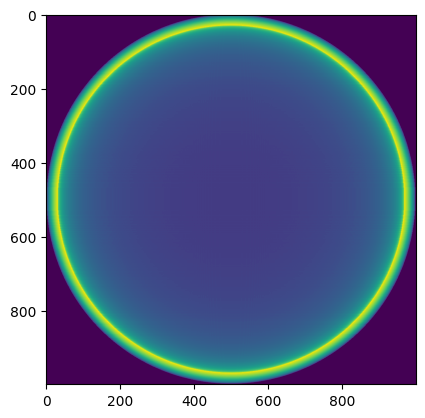

In [92]:
plt.imshow(cell_1 - cell_2)